# XGBoost Regression for Rogue Wave Prediction

In this notebook, we model rogue wave characteristics using an XGBoost regression model. XGBoost (Extreme Gradient Boosting) is a powerful gradient-boosted decision tree algorithm that builds additive models in a forward, stage-wise fashion. Unlike Random Forests, which construct trees independently and average their outputs, XGBoost builds trees sequentially, where each new tree is trained to correct the residual errors of the previous ensemble. This allows XGBoost to learn complex nonlinear patterns with high predictive accuracy and efficiency. XGBoost is particularly well suited for structured tabular data, especially in high-dimensional or noisy settings. Moreover, XGBoost models are robust to outliers, offer built-in regularization mechanisms, and support efficient parallel computation, making them highly scalable for large datasets.

Since XGBoost trees use greedy split thresholds and are not sensitive to feature scaling, standardization of input features is not required. This simplifies preprocessing and maintains interpretability of raw feature values.

To optimize model performance while maintaining a manageable model size (important for downstream interpretability analysis using SHAP), we perform hyperparameter tuning using stratified k-fold cross-validation. Stratification ensures that (rare) rogue wave events are proportionally represented in both training and validation folds.

We tune the following hyperparameters:
- `n_estimators = 100`: Fixed to control model complexity and memory footprint while ensuring sufficient boosting rounds for convergence.
- `max_depth = [6, 10, 20]`: The maximum depth of each tree. Shallower trees generalize better and reduce overfitting, but deeper trees can capture more intricate feature interactions.
- `learning_rate = [0.05, 0.1, 0.2]`: Controls the step size at each boosting round. Lower values lead to slower but more stable learning, which is especially useful when strong regularization is applied.
- `subsample = [0.3, 0.4, 0.5]`: The fraction of training samples used to grow each tree. This acts as a form of stochastic regularization to prevent overfitting and reduce computation time.
- `colsample_bytree = [0.6, 0.8, 1.0]`: The fraction of features randomly selected for each tree. Similar to max_features in Random Forests, this helps decorrelate trees and improve generalization.
- `min_child_weight = [1, 3, 5]`: Minimum sum of instance weights (or number of samples) needed in a child node. Higher values prevent trees from learning overly specific splits, which can reduce overfitting.
- `gamma = [0, 1, 5]`: Minimum loss reduction required to make a further partition. Acts as a pruning parameter; larger values make the algorithm more conservative.
- `reg_alpha = [0, 0.1, 1]`: L1 regularization term (analogous to Lasso). Encourages sparsity in the model by shrinking less informative features toward zero.
- `reg_lambda = [1, 10]`: L2 regularization term (analogous to Ridge). Adds penalty for large coefficients, improving stability in the presence of correlated features.

To evaluate model performance, we compute multiple regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), R² score, and Spearman correlation. MSE penalizes large errors more severely and is sensitive to outliers, while MAE provides a more robust measure of average prediction error. The R² score indicates how much variance in the target is explained by the model, and Spearman correlation assesses whether the model preserves the rank ordering of the predictions, a useful complement to R² when dealing with non-linearities or monotonic relationships.

We also apply SHAP (SHapley Additive exPlanations) to interpret the trained XGBoost model. SHAP provides both global feature importance and local, instance-level explanations, allowing us to assess which features drive the model’s predictions and how those contributions vary across samples. This is especially valuable for validating the model’s alignment with physical understanding of rogue wave formation.

To compute SHAP values efficiently, we use TreeExplainer with the default setting feature_perturbation="tree_path_dependent". This mode is specifically optimized for tree-based models such as XGBoost and does not require an explicit background dataset. Instead, it relies on the internal structure of the trees and the training sample distribution along each path to compute feature contributions. This makes it highly scalable and well suited for our large dataset. Minor differences may occur between the SHAP expected value and the model’s average prediction due to sampling variability in how leaf statistics are recorded during training, but these are typically small and acceptable for practical interpretation.

To match the scale of the model output, we use the default `model_output="raw"` for regression, which returns SHAP values on the original model output scale. This is appropriate for regression tasks, such as ours, where the model directly predicts a continuous target variable (e.g., relative wave height).

We compute SHAP values for both the training and test sets. SHAP values on the training data reflect the model's learned dependencies, while test set explanations highlight how well these generalize to unseen examples. Comparing them helps assess overfitting and provides insight into which features consistently drive model predictions across both in-sample and out-of-sample data.

In [1]:
%load_ext autoreload
%autoreload 2

**Imports**

In [2]:
import os
import sys
import pickle
import shap

from xgboost import XGBRegressor  

sys.path.append('./')
sys.path.append('../scripts/')
import utils

**Parameter Settings**

In [3]:
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [4]:
seed = 42
num_cv = 5

In [5]:
hyperparameter_grid = {
    'n_estimators': [100],
    'max_depth': [6, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.3, 0.4, 0.5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10],
}

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [6]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Model Training**

In [7]:
# Run CV
regressor = XGBRegressor(random_state=seed)
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train, y_train_cat, y_train, n_jobs)

/opt/anaconda3/envs/rw/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
cv_results.sort_values(by="score", ascending=False, inplace=True)

file_cv = f"../results/random_forest/cv_results.csv"
cv_results.to_csv(file_cv)

cv_results

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,score
1730,0.8,0,0.10,20,1,100,0.0,1,0.5,0.958889
272,0.6,0,0.10,20,1,100,0.0,1,0.5,0.958686
3188,1.0,0,0.10,20,1,100,0.0,1,0.5,0.958525
1748,0.8,0,0.10,20,3,100,0.0,1,0.5,0.957973
3206,1.0,0,0.10,20,3,100,0.0,1,0.5,0.957769
...,...,...,...,...,...,...,...,...,...,...
1023,0.6,5,0.05,6,5,100,1.0,10,0.3,0.122696
987,0.6,5,0.05,6,1,100,1.0,10,0.3,0.122696
1347,0.6,5,0.20,6,5,100,1.0,10,0.3,0.121859
1329,0.6,5,0.20,6,3,100,1.0,10,0.3,0.121859


**Model Evaluation**

Evaluate on Training Set


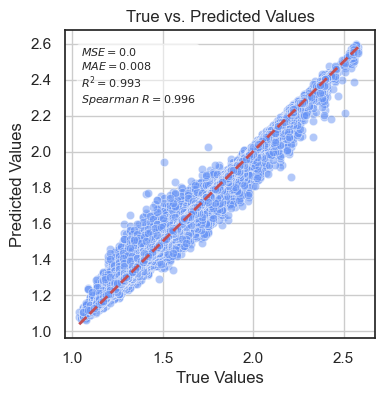

Evaluate on Test Set


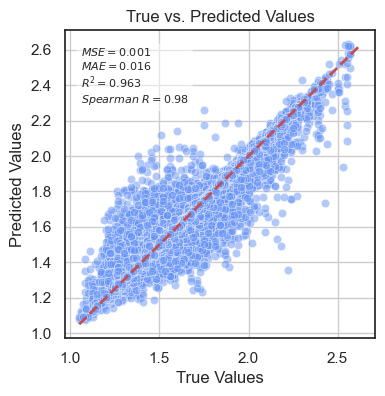

In [9]:
# Evaluate model on train and test set
utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training", plot=True)
utils.evaluate_best_regressor(model, X_test, y_test, dataset="Test", plot=True)

In [10]:
# Save the model
data_and_model = [data_train, data_test, model]

file_data_model = f"../results/xg_boost/model_and_data.pickle"
with open(file_data_model, 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.get_model_size(model)

Model size on disk: 0.1395 GB


**Model Interpretation**